*Transformer* implementation by Tensorflow and make it as a EN to Zh translator
#### What's you can learn from this notebook
1. Word embedding and tokenization
2. Mask mechanisim
3. Basic structure of transformer and it's application as a translator
4. Customized layer and model of tensorflow
5. Checkpoint, tensorflow dashboard


#### Reference:
1. https://leemeng.tw/neural-machine-translation-with-transformer-and-tensorflow2.html#top
2. https://www.tensorflow.org/text/tutorials/transformer


In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output

In [2]:
!pip install tensorflow-gpu==2.0.0-beta0
clear_output()

import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.12.0


In [3]:
import logging
logging.basicConfig(level="error")

np.set_printoptions(suppress=True)

In [4]:
#set up directory
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [5]:
#check out the data source we have
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{Split('train'): ['newscommentary_v14',
                  'wikititles_v1',
                  'uncorpus_v1',
                  'casia2015',
                  'casict2011',
                  'casict2015',
                  'datum2015',
                  'datum2017',
                  'neu2017'],
 Split('validation'): ['newstest2018']}


In [6]:
#download data by tfds.builder
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3'),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

In [7]:
#set builder to dataset(data pipeline type), split it into training, validation, testing
examples = builder.as_dataset(split=['train[:20%]','train[20%:21%]','train[21%:]'], as_supervised=True)

In [8]:
#leave the testing examples this time.
train_examples, val_examples, _ = examples
print(train_examples)
print(val_examples)

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [9]:
for en, zh in train_examples.take(3):
  print(en)
  print(zh)
  print('-' * 10)

tf.Tensor(b'The fear is real and visceral, and politicians ignore it at their peril.', shape=(), dtype=string)
tf.Tensor(b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82', shape=(), dtype=string)
----------
tf.Tensor(b'In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word \xe2\x80\x9cliberal\xe2\x80\x9d \xe2\x80\x93 a champion of the cause of individual freedom.', shape=(), dtype=string)
tf.Tensor(b'\xe4\xba\x8b\xe5\xae\x9e\xe4\xb8\x8a\xef\xbc\x8c\xe5\xbe\xb7\xe5\x9b\xbd\xe6\x94\xbf\xe6\xb2\xbb\xe5\xb1\x80\xe5\x8a\xbf\xe9\x9c\x80\xe8\xa6\x81\xe7\x9a\x84\xe4\xb8\x8d\xe8\xbf\x87\xe6\x98\xaf\xe4\xb8\x80\xe4\xb8\xaa\xe7\xac\xa6\xe5\x90\x88\xe7\xbe\x8e\xe5\x9b\xbd\xe6\x89\x80\xe8\

In [10]:
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")

  print(en)
  print(zh)
  print('-' * 10)


  sample_examples.append((en, zh))

The fear is real and visceral, and politicians ignore it at their peril.
这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
----------
In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word “liberal” – a champion of the cause of individual freedom.
事实上，德国政治局势需要的不过是一个符合美国所谓“自由”定义的真正的自由党派，也就是个人自由事业的倡导者。
----------
Shifting to renewable-energy sources will require enormous effort and major infrastructure investment.
必须付出巨大的努力和基础设施投资才能完成向可再生能源的过渡。
----------
In this sense, it is critical to recognize the fundamental difference between “urban villages” and their rural counterparts.
在这方面，关键在于认识到“城市村落”和农村村落之间的根本区别。
----------
A strong European voice, such as Nicolas Sarkozy’s during the French presidency of the EU, may make a difference, but only for six months, and at the cost of reinforcing other European countries’ nationalist feelings in reaction to the expression of “Gallic pride.”
法国担任轮值主席国期间尼古拉·萨科奇统一的欧洲声音可能让人耳目一新，但这种声音却只持续了短短六个月，而且付出了让其他欧洲国家在面对“高卢人的骄

Word tokenization
1. Scan through the example and create a dictionary of tokens
2. Add BOS and EOS into every sentence
3. Set up a sentence length limitation.
4. Padding every sentence to the same length.
5. Index dictionary as dimension to represent tokens, reducing the dimensions by embedding


In [11]:
#create own eng dictionary in the file of content/nmt/en_vocab #en_vocab_file
#character-delimited + word-delimited
%%time
try:
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"Upload the dictionary： {en_vocab_file}")
except:
  print("No dictionary in the file path, create it.")
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples),
      target_vocab_size=2**13) # The size of dictionary is changable.
  # Subwords as tokens.
  # Save the dictionary to target file path.
  subword_encoder_en.save_to_file(en_vocab_file)


print(f"size of dictionary：{subword_encoder_en.vocab_size}")
print(f"first 10 subwords：{subword_encoder_en.subwords[:10]}")
print()

No dictionary in the file path, create it.
size of dictionary：8113
first 10 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']

CPU times: user 1min 26s, sys: 3.63 s, total: 1min 30s
Wall time: 1min 22s


In [12]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[3461, 7889, 9, 3502, 4379, 1134, 7903]

In [13]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
  subword = subword_encoder_en.decode([idx])
  print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 3461     Taiwan
 7889      
    9     is 
 3502     bea
 4379     uti
 1134     ful
 7903     .


In [14]:
%%time
try:
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"Upload the dictionary： {zh_vocab_file}")
except:
  print("No dictionary in the file path, create it.")
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples),
      target_vocab_size=2**13, # A Chineses word is a token
      max_subword_length=1)

  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"size of dictionary：{subword_encoder_zh.vocab_size}")
print(f"first 10 subwords：{subword_encoder_zh.subwords[:10]}")
print()

No dictionary in the file path, create it.
size of dictionary：4205
first 10 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 6min 43s, sys: 2.58 s, total: 6min 45s
Wall time: 6min 42s


In [15]:
sample_string = sample_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
[10, 151, 574, 1298, 6, 374, 55, 29, 193, 5, 1, 3, 3981, 931, 431, 125, 1, 17, 124, 33, 20, 97, 1089, 1247, 861, 3]


In [16]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 將文字轉成為 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（轉換前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（轉換後）")
print(en_indices)
print(zh_indices)

[英中原文]（轉換前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（轉換後）
[16, 900, 11, 6, 1527, 874, 8, 230, 2259, 2728, 239, 3, 89, 1236, 7903]
[44, 202, 168, 1, 852, 201, 231, 592, 44, 87, 17, 124, 106, 38, 7, 279, 86, 18, 212, 265, 3]


In [17]:
def add_bos_eos(en_t, zh_t):
  # This function will be applied to data set.
  # Add bengin of sentence (BOS) and End of sentence (EOS) and the index of BOS and EOS are the last two index of dictionary
  # Since the index of dictionary start with 0 so subword_encoder_en.vocab_size can be the index of BOS
  # and subword_encoder_en.vocab_size + 1 as index of EOS
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # Same for Zh
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]

  return en_indices, zh_indices

In [18]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = add_bos_eos(en_t, zh_t)
print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n輸入為 2 個 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('輸出為 2 個索引序列：')
pprint((en_indices, zh_indices))

英文 BOS 的 index： 8113
英文 EOS 的 index： 8114
中文 BOS 的 index： 4205
中文 EOS 的 index： 4206

輸入為 2 個 Tensors：
(<tf.Tensor: shape=(), dtype=string, numpy=b'The fear is real and visceral, and politicians ignore it at their peril.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82'>)
---------------
輸出為 2 個索引序列：
([8113,
  16,
  1284,
  9,
  243,
  5,
  1275,
  1756,
  156,
  1,
  5,
  1016,
  5566,
  21,
  38,
  33,
  2982,
  7965,
  7903,
  8114],
 [4205,
  10,
  151,
  574,
  1298,
  6,
  374,
  55,
  29,
  193,
  5,
  1,
  3,
  3981,
  931,
  431,
  125,
  1,
  17,
  124,
  33,
  20,
  97,
  1089,
  1247,
  861,
  3,
  4206])


In [19]:
def tf_add_bos_eos(en_t, zh_t):
  # Both en_t and zh_t are not eager tensors but tensors so it needs to be encapsulated using tf.py_function
  # before applying it to tf.data.dataset.
  # input index can use `tf.int64`
  return tf.py_function(add_bos_eos, [en_t, zh_t], [tf.int64, tf.int64])

# tmp_dataset` for exhibite func
tmp_dataset = train_examples.map(tf_add_bos_eos)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor(
[8113   16 1284    9  243    5 1275 1756  156    1    5 1016 5566   21
   38   33 2982 7965 7903 8114], shape=(20,), dtype=int64)
tf.Tensor(
[4205   10  151  574 1298    6  374   55   29  193    5    1    3 3981
  931  431  125    1   17  124   33   20   97 1089 1247  861    3 4206], shape=(28,), dtype=int64)


In [20]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh are the index list of input
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
train_dataset = tmp_dataset.filter(filter_max_length)

In [21]:

num_examples = 0
for en_indices, zh_indices in train_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1

print(f"所有英文與中文序列長度都不超過 {MAX_LENGTH} 個 tokens")
print(f"訓練資料集裡總共有 {num_examples} 筆數據")

所有英文與中文序列長度都不超過 40 個 tokens
訓練資料集裡總共有 29784 筆數據


In [22]:
BATCH_SIZE = 64
# padding the sentences.
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113   16 1284 ...    0    0    0]
 [8113   44  369 ...    0    0    0]
 [8113 1894 1302 ...    0    0    0]
 ...
 [8113 1668    1 ... 4024 7903 8114]
 [8113 5751 1538 ...    0    0    0]
 [8113 1809 5706 ...    0    0    0]], shape=(64, 71), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   10  151 ...    0    0    0]
 [4205  109   55 ...    0    0    0]
 [4205  206  275 ...    0    0    0]
 ...
 [4205   73   76 ...    0    0    0]
 [4205    5  115 ...    0    0    0]
 [4205    9  270 ...    0    0    0]], shape=(64, 116), dtype=int64)


In [23]:
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# Training
train_dataset = (train_examples # input: En/Zh, Output En/Zh
                 .map(tf_add_bos_eos) # Add BOS and EOS
                 .filter(filter_max_length) #Length <40
                 .cache() #Speed up the process
                 .shuffle(BUFFER_SIZE) # Shuffle the data
                 .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1])) # Pad to same size of example
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# validation
val_dataset = (val_examples
               .map(tf_add_bos_eos)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1])))

In [24]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113  122  130 ...    0    0    0]
 [8113  330  510 ...    0    0    0]
 [8113   41  189 ...    0    0    0]
 ...
 [8113   16 1128 ...    0    0    0]
 [8113  420 7395 ...    0    0    0]
 [8113 5983 1176 ...    0    0    0]], shape=(128, 39), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   29    5 ...    0    0    0]
 [4205   34  614 ...    0    0    0]
 [4205   34    6 ...    0    0    0]
 ...
 [4205   10  151 ...    0    0    0]
 [4205  917  407 ...    0    0    0]
 [4205   96  231 ...    0    0    0]], shape=(128, 40), dtype=int64)


In [25]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


In [26]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 並添加 padding token: <pad> 來確保 batch 裡的句子有一樣長度
demo_dataset = demo_examples.map(tf_add_bos_eos)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出這個 demo dataset 裡唯一一個 batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)


In [27]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

#(2, 8, 4), 2 sentences, 8 tokens, 4 embedding dimensions.
#Demo only here

(<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
 array([[[ 0.02036048, -0.01640828,  0.01218457,  0.04325655],
         [ 0.04816287, -0.0052672 , -0.01734619, -0.00837622],
         [-0.00011305,  0.00515537, -0.03798722,  0.01274326],
         [ 0.00099773,  0.00214062, -0.03265796, -0.01519186],
         [ 0.0038381 , -0.03503789, -0.04649404,  0.03371631],
         [-0.02609479, -0.01476694,  0.01767704, -0.00013995],
         [-0.0470683 ,  0.03534856, -0.01568234, -0.03975261],
         [-0.0470683 ,  0.03534856, -0.01568234, -0.03975261]],
 
        [[ 0.02036048, -0.01640828,  0.01218457,  0.04325655],
         [ 0.03625866, -0.04454783,  0.01512885,  0.01075666],
         [ 0.01096677,  0.00795402, -0.02324426, -0.03262394],
         [-0.02881119, -0.02232167, -0.04458848, -0.02766268],
         [ 0.03149874,  0.0052125 , -0.01925832, -0.04756926],
         [ 0.02321979,  0.02937884,  0.03987649,  0.0045434 ],
         [ 0.0038381 , -0.03503789, -0.04649404,  0.03371631],


# Attention
1. Embedding as input
2. padding mask and look ahead mask
3. Self attention q,k,v
4. Split heads
5. Customized the self attention layers

In [28]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [29]:
print("inp:", inp)
print("-" * 20)
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [30]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力機制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 簡單產生一個跟 `emb_inp` 同樣 shape 的 binary vector
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)
v

<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

In [31]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """
  # 將 `q`、 `k` 做點積再 scale
  # 2D np.dot = tf.matmul
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將遮罩「加」到被丟入 softmax 前的 logits
  # in this case, scaled_attention_logits a tensor with size of (2,8,8) and mask size of (2,1,8), the mask would atuo expand to (2,8,8). It's broadcasting
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  # 以注意權重對 v 做加權平均（weighted average）
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [32]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print("-" * 20)
print("attention_weights:", attention_weights)

#the shape of out still remain (2,8,4). 2 sentences, 8 token long for each sentence and embedding dimension 4. But right now, it has the context and was distilled to a abstract concept of language.

output: tf.Tensor(
[[[0.37527612 0.3748877  0.37489158 0.4999135 ]
  [0.37512815 0.37495762 0.37498188 0.4999887 ]
  [0.37507418 0.37488514 0.3750914  0.49994785]
  [0.3749649  0.37496954 0.3751033  0.49999964]
  [0.3753109  0.37477538 0.3750876  0.49985862]
  [0.3749597  0.37503996 0.37499183 0.5000032 ]
  [0.37460923 0.37512258 0.37515557 0.5000998 ]
  [0.37460923 0.37512258 0.37515557 0.5000998 ]]

 [[0.62505597 0.24990752 0.62515104 0.37506354]
  [0.62504375 0.249929   0.6250835  0.3750168 ]
  [0.6249575  0.25008583 0.6247951  0.3749724 ]
  [0.6248568  0.24982996 0.62478507 0.37468734]
  [0.6249778  0.25016814 0.6247516  0.37503263]
  [0.62512153 0.25022936 0.6251372  0.37529498]
  [0.62491125 0.24970594 0.62490165 0.374762  ]
  [0.6249945  0.24992359 0.62512094 0.3749294 ]]], shape=(2, 8, 4), dtype=float32)
--------------------
attention_weights: tf.Tensor(
[[[0.12519486 0.1250566  0.12502584 0.12495888 0.12512237 0.12502077
   0.12481032 0.12481032]
  [0.12502943 0.12516862 0.125

In [33]:
# 這次讓我們將 padding mask 放入注意函式並觀察
# 注意權重的變化
mask = tf.squeeze(inp_mask, axis=1) # (batch_size, 1, seq_len_q)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("attention_weights:", attention_weights)

#the shape of out still remain (2,8,4). 2 sentences, 8 token long for each sentence and embedding dimension 4. But right now, it has the context and was distilled to a abstract concept of language.

attention_weights: tf.Tensor(
[[[0.16684209 0.16665784 0.16661684 0.16652761 0.16674548 0.16661008
   0.         0.        ]
  [0.16665398 0.1668395  0.16665618 0.16667375 0.16668734 0.16648926
   0.         0.        ]
  [0.16660458 0.16664773 0.16674046 0.1666926  0.16677237 0.16654228
   0.         0.        ]
  [0.16654527 0.16669525 0.16672255 0.16674297 0.16671231 0.16658166
   0.         0.        ]
  [0.16666315 0.16660888 0.16670232 0.16661234 0.166913   0.16650037
   0.         0.        ]
  [0.16668975 0.1665727  0.16663419 0.16664366 0.16666228 0.1667974
   0.         0.        ]
  [0.16645533 0.1665886  0.1667657  0.1668381  0.16657345 0.16677886
   0.         0.        ]
  [0.16645533 0.1665886  0.1667657  0.1668381  0.16657345 0.16677886
   0.         0.        ]]

 [[0.12515603 0.12511945 0.12488692 0.12486453 0.12487849 0.12502903
   0.12508355 0.12498198]
  [0.12508783 0.12518322 0.12491418 0.12489151 0.12496205 0.12496695
   0.12504032 0.12495397]
  [0.12488658 0.124

In [34]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[-0.00003809  0.02078814  0.0123027  -0.0413463 ]
  [-0.01186466 -0.00718495  0.02061463  0.03145773]
  [ 0.03343013 -0.02533985 -0.03888715 -0.00947666]
  [-0.04088186  0.03472645 -0.04847019 -0.03156561]
  [ 0.00073323  0.00582252  0.04584754  0.04327263]
  [-0.02272474 -0.03037575 -0.02887456 -0.04825801]
  [ 0.00737081 -0.02178725  0.00632911 -0.03753779]
  [-0.01153268  0.04393265 -0.02898805  0.01991346]
  [-0.01153268  0.04393265 -0.02898805  0.01991346]
  [-0.01153268  0.04393265 -0.02898805  0.01991346]]

 [[-0.00003809  0.02078814  0.0123027  -0.0413463 ]
  [-0.01225784 -0.00463336 -0.02306047 -0.03860406]
  [-0.02950935  0.00111842  0.03840322  0.04580555]
  [-0.0413953  -0.00827926 -0.00790225 -0.00803288]
  [-0.007319    0.00773299  0.01871021  0.01959158]
  [ 0.02734912 -0.04120228  0.00704892 -0.01005193]
  [ 0.04651746 -0.03131707 -0.03748842  0.04601295]
  [ 0.03838119  0.01310394  0.04108498  0.02070406]
  [-0.02272474 -0.03037575 -0.02887456 -0.

In [35]:
# 讓我們用目標語言（中文）的 batch
# 來模擬 Decoder 處理的情況
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

# 將 look_ahead_mask 放入注意函式
_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.49964964 0.50035036 0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.33315116 0.33303463 0.33381417 0.         0.         0.
   0.         0.         0.         0.        ]
  [0.24999638 0.24959809 0.2498096  0.25059593 0.         0.
   0.         0.         0.         0.        ]
  [0.19990084 0.20023696 0.19977976 0.19966991 0.20041256 0.
   0.         0.         0.         0.        ]
  [0.16668442 0.16646495 0.16673282 0.16683346 0.16630022 0.16698407
   0.         0.         0.         0.        ]
  [0.14290474 0.14275064 0.14288555 0.14280786 0.14271678 0.14297238
   0.14296202 0.         0.         0.        ]
  [0.12496997 0.12497724 0.1249516  0.12516007 0.12497286 0.12491187
   0.12486337 0.125193   0.         0.        ]
  [0.11106536 0.11107182 0.11104903 0.11123431 0.11106793 0.11101373
   0.

In [36]:
#multi-head split the demension of embedding, process them seperately

def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]

  # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度

  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
  # fill in the rest to -1 dimenstion
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))

  # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
  # change the sequence of dimension for better understanding.
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])

  return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)
print("x:", x)
print("output:", output)

x: tf.Tensor(
[[[ 0.02036048 -0.01640828  0.01218457  0.04325655]
  [ 0.04816287 -0.0052672  -0.01734619 -0.00837622]
  [-0.00011305  0.00515537 -0.03798722  0.01274326]
  [ 0.00099773  0.00214062 -0.03265796 -0.01519186]
  [ 0.0038381  -0.03503789 -0.04649404  0.03371631]
  [-0.02609479 -0.01476694  0.01767704 -0.00013995]
  [-0.0470683   0.03534856 -0.01568234 -0.03975261]
  [-0.0470683   0.03534856 -0.01568234 -0.03975261]]

 [[ 0.02036048 -0.01640828  0.01218457  0.04325655]
  [ 0.03625866 -0.04454783  0.01512885  0.01075666]
  [ 0.01096677  0.00795402 -0.02324426 -0.03262394]
  [-0.02881119 -0.02232167 -0.04458848 -0.02766268]
  [ 0.03149874  0.0052125  -0.01925832 -0.04756926]
  [ 0.02321979  0.02937884  0.03987649  0.0045434 ]
  [ 0.0038381  -0.03503789 -0.04649404  0.03371631]
  [-0.02609479 -0.01476694  0.01767704 -0.00013995]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[ 0.02036048 -0.01640828]
   [ 0.04816287 -0.0052672 ]
   [-0.00011305  0.00515537]
   [ 0.0009

In [37]:
# Implement a multi-head attention layer by inheriting tf.keras.layers.Layer
# initialize by dimension of model
# initialize q, k, v using tf.keras.layers.Dense
# ouput a attension result and attension weights matrix
# output.shape = (batch_size, seq_len_q, d_model)
# attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0  #make sure dimenstions of embedding can be divided.

    self.depth = d_model // self.num_heads  #depth in every head

    self.wq = tf.keras.layers.Dense(d_model)  # input of q matual wq.
    self.wk = tf.keras.layers.Dense(d_model)  # No activation func
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)  # for combining mutiple heads.

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])


  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0] #number of examples

    # project q, k, v to embedding dimensions for example (2,8,4). 2 sentences, 8 tokens, 4 dimensions
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    # split heads from (2,8,4) to (2,2,8,2)
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    #pass q, k, v and mask to self attention.
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)

    # Reverse the process of splitting heads.
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
    # (batch_size, seq_len_q, d_model)

    # final layer
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [38]:
# emb_inp.shape = (batch_size, seq_len, d_model) = (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# set v = k = q = embedded examples (2,8,4), 2 examples, 8 tokens, and 4 dimensions of embedding.
# shape of inp: (2,8) shape of imp_inp = (2,8,4)
# padding mask
# The last tokens of en embedding is <pad>
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, padding_mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape) # (..., seq_len_q, seq_len_k)

print("\noutput:", output)

# attention_weights.shape: (2, 2, 8, 8): 2 batches, 2 heads, 8 words (attention: 8x8)
# mask shape=(2, 1, 8)
# it's a demonstration with 2 sentences as inputs

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[ 0.01943418  0.01492455 -0.01133173  0.00566184]
  [ 0.01942845  0.0149345  -0.01133365  0.00566607]
  [ 0.01943423  0.01492351 -0.0113328   0.0056646 ]
  [ 0.01943006  0.0149283  -0.0113328   0.00566612]
  [ 0.01943646  0.0149101  -0.01132837  0.00566153]
  [ 0.0194295   0.01492632 -0.01133089  0.0056637 ]
  [ 0.01942803  0.01493593 -0.01133532  0.00566828]
  [ 0.01942803  0.01493593 -0.01133532  0.00566828]]

 [[ 0.01569175 -0.00030142 -0.00823727 -0.00749162]
  [ 0.01568969 -0.00029713 -0.008238   -0.00748959]
  [ 0.01568775 -0.00025613 -0.00825429 -0.00748615]
  [ 0.01568913 -0.00028356 -0.00824393 -0.00748797]
  [ 0.01568655 -0.00024629 -0.00825767 -0.00748472]
  [ 0.01568835 -0.00025425 -0.00825493 -0.00748796]
  [ 0.0156928  -0.00031582 -0.00823224 -0.00749175]
  [ 0.01568932 -0.000

Model building
1. Define the feed foward layer after attension
2. Define the Encoder layer
3. Define positional encoding layer
4. Stack up the encoder
5. repeat steps above, build up a decoder, only the decoder has two layers of mha
6. combine encoder layers and decoder layers into transformer.



In [39]:
# Feed foward layer after attention layer.
def point_wise_feed_forward_network(d_model, dff):
  #d_model: demensions of the embedding
  #dff neurons in the middle layer.

  # relu in the middle layer: FNN with one layer.
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [40]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

#64 examples, 10 tokens, 512 dimensions of embeddin.

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


In [41]:
d_model = 4 # FFN 的輸入輸出張量的最後一維皆為 `d_model`
dff = 6

# 建立一個小 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)
# 懂子詞梗的站出來
dummy_sentence = tf.constant([[5, 5, 6, 6],
                              [5, 5, 6, 6],
                              [9, 5, 2, 7],
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[1.1989949, 4.4507575, 2.7113478, 3.5615683],
       [1.1989949, 4.4507575, 2.7113478, 3.5615683],
       [6.0208206, 5.107947 , 6.76421  , 4.80589  ],
       [6.0208206, 5.107947 , 6.76421  , 4.80589  ],
       [6.0208206, 5.107947 , 6.76421  , 4.80589  ]], dtype=float32)>

In [42]:
# An encoder incoperates 2 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Default dropout rate is 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer normalization to normalized the attention from a sentence.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # One layer should have one dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  # training argument to decide whether on training or not.
  def call(self, x, training, mask):

    # x is embedding + positional encoding with shape (batch_size, input_seq_len, d_model)
    # attn shape = (batch_size, num_heads, input_seq_len, input_seq_len)
    # sub-layer 1: MHA
    # set q, k, v as x
    # padding mask to mask <pad>
    attn_output, attn = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    # sub-layer 2: FFN
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [43]:
d_model = 4
num_heads = 2
dff = 8

enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp) #inp = (2,8), 2 examples, 8 tokens
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

#encoder needs only padding mask. Input a whole sentence of English (inp: (2,8)), transfer it using embedding (emb_inp: (2,8,4)), and transfer it to a vector of represent (enc_out, (2,8,4))
#And the vector that incorperates the meaning of the sentence would diliver it to the decoder
#Shape of enc_out = (2,8,4), (batch_size, seq_len_q, num_heads * depth). 2 examples, 8 sums of attentions by each token to other tokens in the sentences, attentions from mutiheads.

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[ 0.02036048 -0.01640828  0.01218457  0.04325655]
  [ 0.04816287 -0.0052672  -0.01734619 -0.00837622]
  [-0.00011305  0.00515537 -0.03798722  0.01274326]
  [ 0.00099773  0.00214062 -0.03265796 -0.01519186]
  [ 0.0038381  -0.03503789 -0.04649404  0.03371631]
  [-0.02609479 -0.01476694  0.01767704 -0.00013995]
  [-0.0470683   0.03534856 -0.01568234 -0.03975261]
  [-0.0470683   0.03534856 -0.01568234 -0.03975261]]

 [[ 0.02036048 -0.01640828  0.01218457  0.04325655]
  [ 0.03625866 -0.04454783  0.01512885  0.01075666]
  [ 0.01096677  0.00795402 -0.02324426 -0.03262394]
  [-0.02881119 -0.02232167 -0.04458848 -0.02766268]
  [ 0.03149874  0.0052125  -0.01925832 -0.04756926]
  [

In [44]:
# postitional encoding
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])

  pos_encoding = np.concatenate([sines, cosines], axis=-1)

  pos_encoding = pos_encoding[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

In [45]:
class Encoder(tf.keras.layers.Layer):
  # An encoder incorperates embedding layer, postional encoding layer, layers of encoder layer
  # num_layers: layers of encoder layer
  # input_vocab_size: size of dictionary
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
          rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)

    # How many encoder layers in a list.
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
               for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    # x.shape == (batch_size, input_seq_len)
    # output of following layers (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]

    # embedding + regularization + postional encoding + dropout
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]
    x = self.dropout(x, training=training)

    # N layers of encoder layer
    for enc_layer in self.enc_layers:
      x = enc_layer(x, training, mask)
    return x

In [46]:
#hyperparameters
num_layers = 2 # encoder with 2 layers of encoder layer
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # size of en dictionary + 2 (<BOS> and <EOS>)

# Initialize an encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# it's a demo, inp = (2,8)
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-0.45686638 -0.8393616   1.7079813  -0.41175342]
  [-0.2950113  -1.4189955   1.3209585   0.3930482 ]
  [-0.34067458  0.03478408 -1.2319627   1.5378532 ]
  [-0.833727    1.2468072  -1.1189682   0.7058879 ]
  [-1.2866867   1.3791683  -0.5142436   0.4217617 ]
  [-1.2922702   0.13546768  1.4846532  -0.32785073]
  [-0.4533368  -0.71503425  1.7245061  -0.55613506]
  [-0.30388275 -1.2746067   1.5093889   0.06910065]]

 [[-0.48948804 -0.73142445  1.7240318  -0.50311935]
  [-0.3522867  -1.296598    1.4707067   0.1781781 ]
  [-0.4410661  -0.3201995  -0.9257293   1.6869948 ]
  [-0.82980764  1.1963218  -1.1353768   0.7688626 ]
  [-1.4434403   1.2967441  -0.261444    0.4081403 ]
  [-1.0381074  -0.15711333  1.6424468  -0.44722617]
  [-0.54026175 -0.54983324  1.7307208  -0.6406257 ]
  [-0.37507418 -1.1826677   1.5685968  -0.0108

In [47]:
# Decoder incorperates N DecoderLayer，
# and DecoderLayer has 3 sub-layers: self attention MHA, attention of Encoder MHA and FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    # 3 types of sublayer in the decoder layer
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # LayerNorm for every sub layer
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # drop for every sub-layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           combined_mask, inp_padding_mask):
    # shape of output of all sublayers are (batch_size, target_seq_len, d_model)
    # enc_output is the ouput of Encoder with shape (batch_size, input_seq_len, d_model)
    # shape of attn_weights_block_1: (batch_size, num_heads, target_seq_len, target_seq_len)
    # shape of attn_weights_block_2: (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer, self attention of the decoder input
    # Need look ahead mask and padding mask: conbined_mask
    # x: cn input. tokens before the next one
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    # sub-layer 2: Decoder layer: attention of encoder.
    # Need padding mask only.
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output,
                          out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    # sub-layer 3: FFN
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [48]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)
# stack up two masks for decoder

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

In [49]:
# hyperparameters
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# Both inp and tar (en for encoder and ch for decoder) need padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# lood ahead mask + padding mask for target input.
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# enc_out from encoder. emb_tar hasn't applying positional encoding yet.
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
                                     emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)


#shape of emb_tar: (2, 10, 4). 2 examples, 10 tokens, 4 embedding dimensions of zh embedding
#shape of enc_out: (2, 8, 4). 2 examples, 8 tokens, 4 embedding dimensions of en embedding
#shape of dec_out: (2, 10 , 4). 2 examples, 8 sums of attention from other tokens, 2 heads * 2 depth (multi heads)
#shape of dec_self_attn_weights (2, 2, 10, 10): 2 examples, 2 heads. 10 x 10 attentions. 10 tokens and their attentions on each others
#shape of dec_enc_attn_weights (2, 2, 10, 8): 2 examples, 2 heads, 10 x 8 attentions. 10 tokens and their attentions on encoder.

emb_tar: tf.Tensor(
[[[-0.00003809  0.02078814  0.0123027  -0.0413463 ]
  [-0.01186466 -0.00718495  0.02061463  0.03145773]
  [ 0.03343013 -0.02533985 -0.03888715 -0.00947666]
  [-0.04088186  0.03472645 -0.04847019 -0.03156561]
  [ 0.00073323  0.00582252  0.04584754  0.04327263]
  [-0.02272474 -0.03037575 -0.02887456 -0.04825801]
  [ 0.00737081 -0.02178725  0.00632911 -0.03753779]
  [-0.01153268  0.04393265 -0.02898805  0.01991346]
  [-0.01153268  0.04393265 -0.02898805  0.01991346]
  [-0.01153268  0.04393265 -0.02898805  0.01991346]]

 [[-0.00003809  0.02078814  0.0123027  -0.0413463 ]
  [-0.01225784 -0.00463336 -0.02306047 -0.03860406]
  [-0.02950935  0.00111842  0.03840322  0.04580555]
  [-0.0413953  -0.00827926 -0.00790225 -0.00803288]
  [-0.007319    0.00773299  0.01871021  0.01959158]
  [ 0.02734912 -0.04120228  0.00704892 -0.01005193]
  [ 0.04651746 -0.03131707 -0.03748842  0.04601295]
  [ 0.03838119  0.01310394  0.04108498  0.02070406]
  [-0.02272474 -0.03037575 -0.02887456 -0.

In [50]:
class Decoder(tf.keras.layers.Layer):
  #applying target_vocab_size as input
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
             rate=0.1):
    super().__init__()

    self.d_model = d_model
    #cn dictionary as input
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
               for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           combined_mask, inp_padding_mask):

    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  #for attentions of decoder itself.

    # same process as encoder.
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                        combined_mask, inp_padding_mask)

      # save the weighting of attention layers of the decoder.
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

    # x.shape = (batch_size, tar_seq_len, d_model)
    return x, attention_weights

In [51]:
# hyperparameters
num_layers = 2 # 2 layers of decoder layers
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # cn dictionary + 2 (<BOS>,<EOS>)

# decoder need both look ahead and padding
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# intial a decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# it's an example, set input as tar (2,10)
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False,
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

#shape of tar: (2, 10). 2 examples, 10 tokens
#shape of enc_out: (2, 8, 4). 2 examples, 8 tokens, 4 embedding dimensions of en embedding
#shape of dec_out: (2, 10, 4). 2 examples, 8 sums of attention from other tokens, 2 heads * 2 depth (multi heads)
#shape of decoder_layer1_block1 (2, 2, 10, 10): 2 examples, 2 heads. 10 x 10 attentions. 10 tokens and their attentions on each others
#shape of decoder_layer1_block2 (2, 2, 10, 8): 2 examples, 2 heads, 10 x 8 attentions. 10 tokens and their attentions on encoder.
#shape of decoder_layer2_block1 (2, 2, 10, 10)
#shape of decoder_layer2_block2 (2, 2, 10, 8)


tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-0.45686638 

In [116]:
# Inherited from tf.keras.Model
class Transformer(tf.keras.Model):
  # arguments comprise argements of encoder, decoder and size of both en and ch dictionary.
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                target_vocab_size, rate)
    # the size of ffn is euqal to ch dictionary. So when passing through softmax layer, it would generate the probability of each tokens.
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  # enc_padding_mask and dec_padding_mask are both padding mask generated from en，
  # One is for Encoder layer's MHA and the other is for Decoder layer's MHA 2
  def call(self, inp, tar, training, enc_padding_mask,
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape = (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training,
                            combined_mask, dec_padding_mask)

    # last fnn layer before softmax.
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [53]:
tar[:,:-1]

<tf.Tensor: shape=(2, 9), dtype=int64, numpy=
array([[4205,   10,  241,   86,   27,    3, 4206,    0,    0],
       [4205,  165,  489,  398,  191,   14,    7,  560,    3]])>

In [54]:
# hyperparameter
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 for <BOS> & <EOS> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# For predicting next word.
# size of tar is (2,10),
# tar[:, :-1] (2,9) the first token to 2 from the last. skip the last token. it's something the docoder read
# and tar[:, 1:] from the second to the last. this is somthing we hope that decoder can generate.
tar_inp = tar[:, :-1] # input of decoder.
tar_real = tar[:, 1:] # it's the next token of tar_inp. tar[:, 0] vs. tar[:, 1]

# combined mask for decoder to generate next work.
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# intialize the transformer
transformer = Transformer(num_layers, d_model, num_heads, dff,
              input_vocab_size, output_vocab_size)

# call the transformer
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask,
                      combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

#when decoder recieve first token from tar[:, 0] (<BOS> here), with the help of encoder,
#the target of decoder is tar[:, 1]. (10 here)
# the size of tar_real is (2,9) and the ouput size of prediction is (2,9,4107) where 4107 is the size of ch dictionary.
# 2 examples, 9 next tokens (start from <BOS>), 4107 options in the ch dictionary for decoder.

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0]
 [4205  165  489  398  191   14    7  560    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   86   27    3 4206    0    0    0]
 [ 165  489  398  191   14    7  560    3 4206]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[-0.05528152  0.06290096  0.01011402 ...  0.02043662 -0.01187914
   -0.01241975]
  [ 0.01190244  0.02488848  0.0181387  ...  0.01180054  0.00191411
    0.03780356]
  [ 0.05305054 -0.02048023 -0.00167435 ... -0.00253333  0.0179859
    0.04105541]
  ...
  [-0.03011649  0.05489373  0.00015077 ...  0.02016029  0.00222181
    0.00296855]
  [ 0.01319736  0.04381273  0.00933154 ...  0.02031524  0.01260706
    0.04588727]
  [ 0.06249398 -0.03151139 -0.00996228 ... -0.0060

Training process
1. Define loss function, and it's metrics
2. Get rid of the loss of padding
3. Define the optimizer using schedule

In [56]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

#logits mean the sum of input is not equal to one. Haven't gone through the softmax layer
#reduction = none means don't add up all the error here because we intent to get rid of padding loss later.

real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.31326175, 0.31326175, 1.3132617 ], dtype=float32)>

In [57]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))

predictions: tf.Tensor(
[[[-0.05528152  0.06290096  0.01011402 ...  0.02043662 -0.01187914
   -0.01241975]
  [ 0.01190244  0.02488848  0.0181387  ...  0.01180054  0.00191411
    0.03780356]
  [ 0.05305054 -0.02048023 -0.00167435 ... -0.00253333  0.0179859
    0.04105541]
  ...
  [-0.03011649  0.05489373  0.00015077 ...  0.02016029  0.00222181
    0.00296855]
  [ 0.01319736  0.04381273  0.00933154 ...  0.02031524  0.01260706
    0.04588727]
  [ 0.06249398 -0.03151139 -0.00996228 ... -0.00601428  0.02358194
    0.03932164]]

 [[-0.05479728  0.0627923   0.00985205 ...  0.02045237 -0.01155618
   -0.01213498]
  [ 0.00161882  0.03684713  0.02106856 ...  0.01569221 -0.00080699
    0.03624023]
  [ 0.04768933 -0.01556457  0.00194348 ... -0.00111728  0.01504009
    0.04059804]
  ...
  [-0.02717381  0.05338851 -0.00085949 ...  0.01987886  0.00362705
    0.0045034 ]
  [ 0.0051162   0.05029279  0.01299925 ...  0.02208429  0.0089016
    0.04362247]
  [ 0.05619376 -0.02387699 -0.00405207 ... -0.00358

In [117]:
def loss_function(real, pred):
  # tar[:, :-1] as real, output of decoder as pred
  # mask out the the padding where is 0 in the tar[:, :-1]
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # loss of all postiion in (2,9)
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # mask out <pad>

  return tf.reduce_mean(loss_)

def masked_accuracy(real, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(real, pred.dtype)
  match = real == pred

  mask = real != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [60]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
                               name='train_accuracy')

In [118]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # default

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8115
target_vocab_size: 4207


In [119]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # default `warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Put learning rate schdeule into Adam opt.
# Adam opt. 的參數都跟論文相同
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

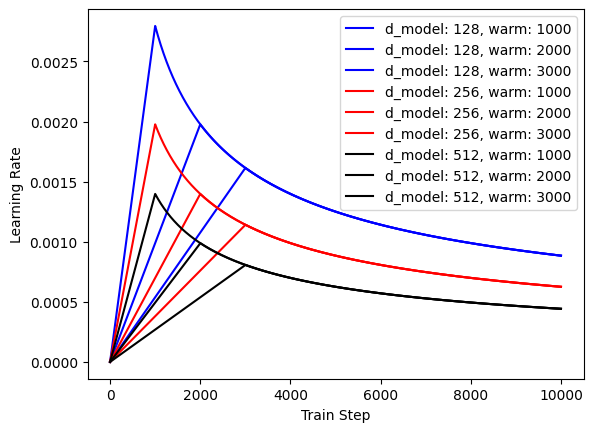

In [63]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)),
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [122]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""This Transformer incorperates {num_layers}  Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

This Transformer incorperates 4  Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8115
target_vocab_size: 4207
dropout_rate: 0.1




In [121]:
# transformer.compile(
#     loss=loss_function,
#     optimizer=optimizer,
#     metrics=[masked_accuracy])

In [114]:
# transformer.fit(train_examples,
#                 epochs=20,
#                 validation_data=val_examples)
# Need custom training process

ValueError: ignored

In [124]:
def create_masks(inp, tar):
  enc_padding_mask = create_padding_mask(inp)
  dec_padding_mask = create_padding_mask(inp)
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [125]:
@tf.function  # engar mode to speed up training
def train_step(inp, tar):

  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  #create masks
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

   # start the scope of gradient
  with tf.GradientTape() as tape:
    # forward pass, use tar_inp instead of tar, setting training as True
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    # calculate the loss
    loss = loss_function(tar_real, predictions)

  # calculate the gradient, and update tranable variables in the transformer
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  # tensor board
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [144]:
EPOCHS = 30

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(EPOCHS):
  start = time.time()

  # reset TensorBoard metrics
  train_loss.reset_states()
  train_accuracy.reset_states()

  # training steps and train data
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))



Epoch 1 Loss 1.4830 Accuracy 0.3620
Time taken for 1 epoch: 25.76222062110901 secs

Epoch 2 Loss 1.4306 Accuracy 0.3694
Time taken for 1 epoch: 15.09987187385559 secs

Epoch 3 Loss 1.3839 Accuracy 0.3766
Time taken for 1 epoch: 15.678091287612915 secs

Epoch 4 Loss 1.3420 Accuracy 0.3828
Time taken for 1 epoch: 16.24576711654663 secs

Epoch 5 Loss 1.3032 Accuracy 0.3887
Time taken for 1 epoch: 16.471293687820435 secs

Epoch 6 Loss 1.2658 Accuracy 0.3943
Time taken for 1 epoch: 15.99833369255066 secs

Epoch 7 Loss 1.2331 Accuracy 0.3992
Time taken for 1 epoch: 16.511935234069824 secs

Epoch 8 Loss 1.2027 Accuracy 0.4038
Time taken for 1 epoch: 16.205184936523438 secs

Epoch 9 Loss 1.1741 Accuracy 0.4082
Time taken for 1 epoch: 16.25140619277954 secs

Epoch 10 Loss 1.1476 Accuracy 0.4127
Time taken for 1 epoch: 15.98979115486145 secs



In [173]:
def evaluate(inp_sentence):

  # find position of <BOS>, <EOS>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]

  # subword_encoder_en.encode(inp_sentence) is the list of position in the dictionary of given sentences
  # add <BOS>, <EOS> to the given sentence
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  #print(inp_sentence)

  # The input of decoder is zh with only <BOS>
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)


  # auto-regressive，generate new token and feed it back to Transformer
  for i in range(MAX_LENGTH):
    # Create new mask for every new generated token
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape = (batch_size, seq_len, vocab_size)
    # forward pass
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
    # size of prediction go from (2, 1, 4207) to (2, 9, 4207). -1 means the next token
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32) #get max out of 4107

    # if predicted_id = <EOS> then stop translating
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights

    #add predicted_id to the out and feed it back to transformer.
    # [<BOS>, predicted_id ....]
    output = tf.concat([output, predicted_id], axis=-1)

  # return output result and attention weighting
  return tf.squeeze(output, axis=0), attention_weights

In [140]:
#pip install opencc-python-reimplemented

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 5.7 MB/s eta 0:00:00


In [141]:
from opencc import OpenCC

# simplified chinese to tranditional chinese
def simplified_to_traditional(simplified_text):
    cc = OpenCC('s2t')  # s2t: Simplified to Traditional
    traditional_text = cc.convert(simplified_text)
    return traditional_text

In [191]:
# taret en sentence
sentence = "Many countries on earth are suffering from a great inflation"

# predicted seq, translated zh sentence
predicted_seq, _ = evaluate(sentence)


# filter out <BOS> & <EOS> tokens and transfer subword tokenizer to zh sentence
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", simplified_to_traditional(predicted_sentence))

#If the en input is only one word 'good'. the predicted chinese token start with '好' but
#the following word is not <EOS> instead it continuing to translate..
#training materials if from newscommentary, so the model prone to speak political language.

sentence: Many countries on earth are suffering from a great inflation
--------------------
predicted_seq: tf.Tensor(
[4205  215   53    4   33    5  189   40  482   18  170  607    1  403
  571   16  189   40   14  482   18    1  170  607    3], shape=(25,), dtype=int32)
--------------------
predicted_sentence: 許多國家在受到巨大通脹的威脅中受到了巨大的通脹。


In [134]:
transformer.summary()

Model: "transformer_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_16 (Encoder)        multiple                  1831808   
                                                                 
 decoder_16 (Decoder)        multiple                  1596800   
                                                                 
 dense_1047 (Dense)          multiple                  542703    
                                                                 
Total params: 3,971,311
Trainable params: 3,971,311
Non-trainable params: 0
_________________________________________________________________


In [135]:
predicted_seq, attention_weights = evaluate(sentence)

# 在這邊我們自動選擇最後一個 Decoder layer 的 MHA 2，也就是 Decoder 關注 Encoder 的 MHA
layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
  print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: China, India, and others have enjoyed continuing economic growth.
--------------------
predicted_seq: tf.Tensor(
[4205   16    4   36  378  100    8   35   32    4   33  111    5  530
  294  556  632   22   49  105   83    3], shape=(22,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 22, 22)
decoder_layer1_block2.shape: (1, 8, 22, 15)
decoder_layer2_block1.shape: (1, 8, 22, 22)
decoder_layer2_block2.shape: (1, 8, 22, 15)
decoder_layer3_block1.shape: (1, 8, 22, 22)
decoder_layer3_block2.shape: (1, 8, 22, 15)
decoder_layer4_block1.shape: (1, 8, 22, 22)
decoder_layer4_block2.shape: (1, 8, 22, 15)
--------------------
layer_name: decoder_layer4_block2


In [138]:
!apt-get install -y fonts-wqy-zenhei
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-wqy-zenhei
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 7,472 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8 [7,472 kB]
Fetched 7,472 kB in 1s (5,697 kB/s)
Selecting previously unselected package fonts-wqy-zenhei.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../fonts-wqy-zenhei_0.9.45-8_all.deb ...
Unpacking fonts-wqy-zenhei (0.9.45-8) ...
Setting up fonts-wqy-zenhei (0.9.45-8) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache conte

In [136]:
import matplotlib as mpl
# 你可能會需要自行下載一個中文字體檔案以讓 matplotlib 正確顯示中文
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')
plt.style.use("seaborn-whitegrid")

# 這個函式將英 -> 中翻譯的注意權重視覺化（注意：我們將注意權重 transpose 以最佳化渲染結果
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    fig = plt.figure(figsize=(17, 7))

    sentence = subword_encoder_en.encode(sentence)

    if max_len_tar:
        predicted_seq = predicted_seq[:max_len_tar]
    else:
        max_len_tar = len(predicted_seq)

    attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)

    for head in range(attention_weights.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
        ax.matshow(attn_map, cmap='viridis')

        fontdict = {"fontproperties": zhfont}

        ax.set_xticks(range(max_len_tar))
        ax.set_xlim(-0.5, max_len_tar - 1.5)

        # Use a consistent list of tick labels for the y-axis
        y_tick_labels = ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>']
        ax.set_yticks(range(len(y_tick_labels)))
        ax.set_yticklabels(y_tick_labels, fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

<ipython-input-136-facad4ff69b6>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


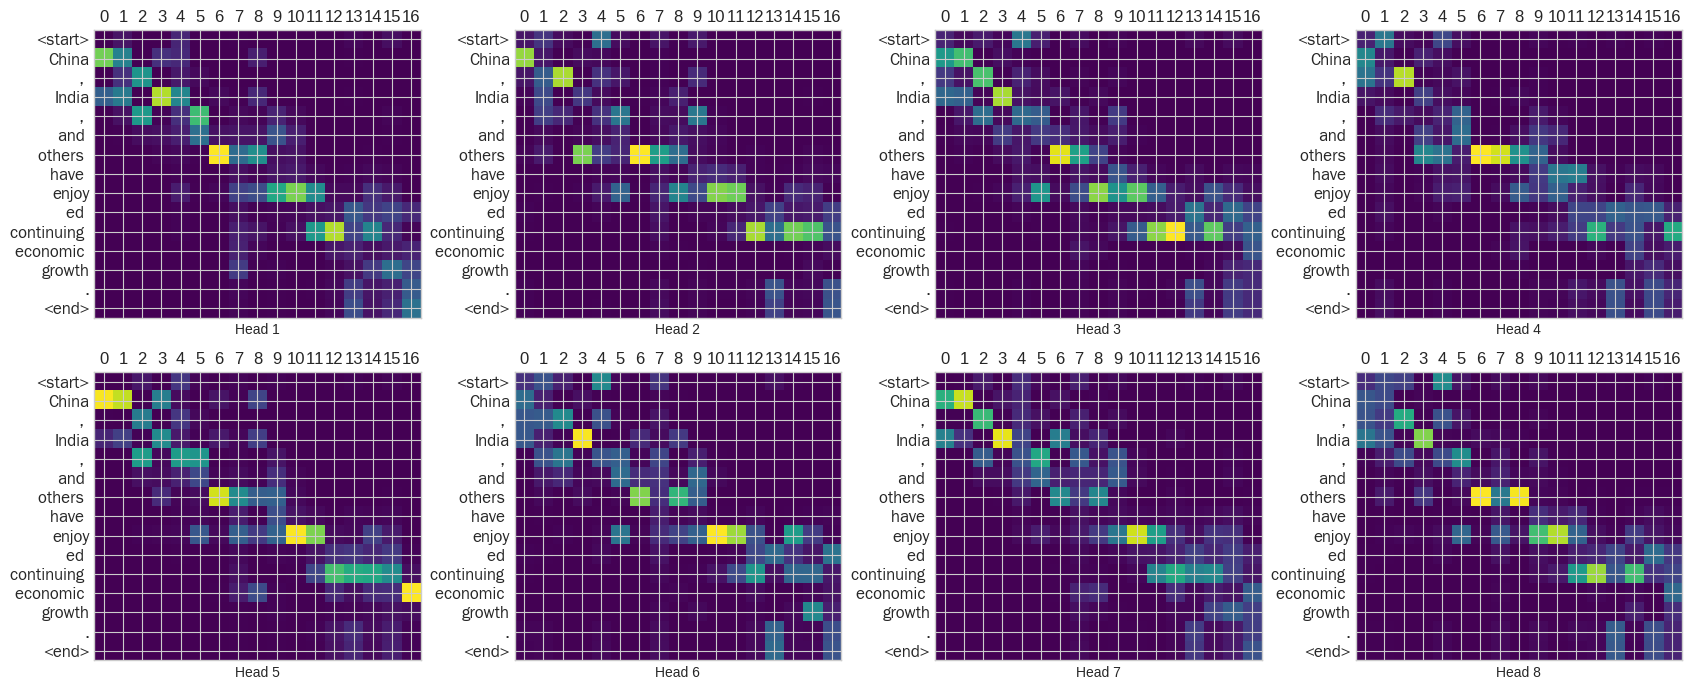

In [139]:
plot_attention_weights(attention_weights, sentence,
                       predicted_seq, layer_name, max_len_tar=18)